In [2]:
pip install datatable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import random
import string
from datetime import datetime
import os
from matplotlib import pyplot as plt
import h5py
import warnings
import datatable as dt
import msgpack
warnings.simplefilter(action='ignore', category=FutureWarning)

In [28]:
types = ['int', 'float', 'string', 'boolean']

def int_column(length) :

    column = []
    for i in range(length) :
        column.append(random.randint(-2147483648, 2147483647))
    return column

def float_column(length) :
    column = []
    for i in range(length) :
        column.append(random.uniform(-100, 100))
    return column

def boolean_column(length) :
    column = []
    for i in range(length) :
        column.append(bool(random.randint(0,1)))
    return column

def string_column(length) :
    column = []
    letters = string.ascii_lowercase
    for i in range(length) :
        column.append(''.join([random.choice(letters) for j in range(random.randint(0,10))]))
    return column

def column(column_type, length) :
    if types[column_type] == 'int' :
        return int_column(length)
    elif types[column_type] == 'float':
        return float_column(length)
    elif types[column_type] == 'boolean' :
        return boolean_column(length)
    elif types[column_type] == 'string' :
        return string_column(length)

def write_hdf(filename, ds) :
    ds = pd.concat([pd.DataFrame(ds.columns), ds], axis=1)
    new_ds = pd.DataFrame([ds[i].astype('string') for i in ds.columns]).T.T
    with h5py.File(filename, 'w') as f:
        f.create_dataset('dataset', data=new_ds.values)

def read_hdf(filename) :
    with h5py.File(filename, "r") as f:
        a_group_key = list(f.keys())[0]
        readed_ds = h5py.Dataset.asstr(f[a_group_key])
        ds = pd.DataFrame(list(readed_ds[1:]))
        ds.columns = list(readed_ds[0])
        return ds

def write_jay(filename, ds) :
  ddt = dt.Frame([i.astype(str) for i in ds.values])
  ddt.names = list(ds.columns)
  ddt.to_jay('results/dataset.jay', method='auto')

def write_msgpack(filename, ds) :
  with open(filename, "wb") as outfile:
    packed = msgpack.packb(ds.to_dict())
    outfile.write(packed)

def read_msgpack(filename) :
  with open('results/dataset.msg', "rb") as data_file:
    byte_data = data_file.read()
    data_loaded = msgpack.unpackb(byte_data, strict_map_key=False)
    return pd.DataFrame(data_loaded)

In [29]:
def main() :
    #columns_num = random.randint(1, 100)
    #rows_num = random.randint(1, 100)
    #dim = columns_num * rows_num

    ds = pd.DataFrame()
    columns_num = 256
    rows_num = 256

    for i in range(columns_num) :
        type = random.randint(0, 2)
        ds = pd.concat([ds, pd.DataFrame(column(type, rows_num), columns=['col' + str(i) + "_" + types[type]])], axis=1)
        ds.iloc[:, -1] = ds.iloc[:, -1].astype(types[type])

    start_csv = datetime.now()
    ds.to_csv('results/dataset.csv', index=False)
    start_feather = datetime.now()
    ds.reset_index(drop=True).to_feather('results/dataset.feather')
    start_hdf = datetime.now()
    write_hdf('results/dataset.hdf5', ds)
    start_msgpack = datetime.now()
    write_msgpack('results/dataset.msg', ds)
    start_parquet = datetime.now()
    ds.to_parquet('results/dataset.gzip', compression='gzip')
    start_pickle = datetime.now()
    ds.to_pickle('results/dataset.pkl')
    start_jay = datetime.now()
    write_jay('results/dataset.jay', ds)
    end_time = datetime.now()


    result = pd.DataFrame()
    result['file'] = ['csv', 'feather', 'hdf', 'msgpack', 'parquet', 'pickle', 'jay']
    result['save_time'] = [(start_feather - start_csv).microseconds, (start_hdf - start_feather).microseconds,
                           (start_msgpack - start_hdf).microseconds, (start_parquet - start_msgpack).microseconds,
                           (start_pickle - start_parquet).microseconds, (start_jay - start_pickle).microseconds,
                           (end_time - start_jay).microseconds]

    start_csv = datetime.now()
    ds = pd.read_csv('results/dataset.csv')
    start_feather = datetime.now()
    ds = pd.read_feather('results/dataset.feather')
    start_hdf = datetime.now()
    ds = read_hdf('results/dataset.hdf5')
    start_msgpack = datetime.now()
    ds = read_msgpack('results/dataset.msg')
    start_parquet = datetime.now()
    ds = pd.read_parquet('results/dataset.gzip')
    start_pickle = datetime.now()
    ds = pd.read_pickle('results/dataset.pkl')
    start_jay = datetime.now()
    ds = dt.fread('results/dataset.jay')
    end_time = datetime.now()

    result['load_time'] = [(start_feather - start_csv).microseconds, (start_hdf - start_feather).microseconds,
                           (start_msgpack - start_hdf).microseconds, (start_parquet - start_msgpack).microseconds,
                           (start_pickle - start_parquet).microseconds, (start_jay - start_pickle).microseconds,
                           (end_time - start_jay).microseconds]

    result['size'] = [os.stat('results/dataset.csv').st_size, os.stat('results/dataset.feather').st_size,
                      os.stat('results/dataset.hdf5').st_size, os.stat('results/dataset.msg').st_size,
                      os.stat('results/dataset.gzip').st_size, os.stat('results/dataset.pkl').st_size, os.stat('results/dataset.jay').st_size]

    return result

      file  save_time  load_time       size
0      csv    65941.0    43539.0   778349.0
1  feather    33572.0    21698.0   623466.0
2      hdf   192668.0    63007.0  3160064.0
3      jay    58844.0     1167.0   992240.0
4  msgpack    77113.0    35946.0   536869.0
5  parquet    74430.0    36816.0   628710.0
6   pickle     9209.0     7853.0   549185.0


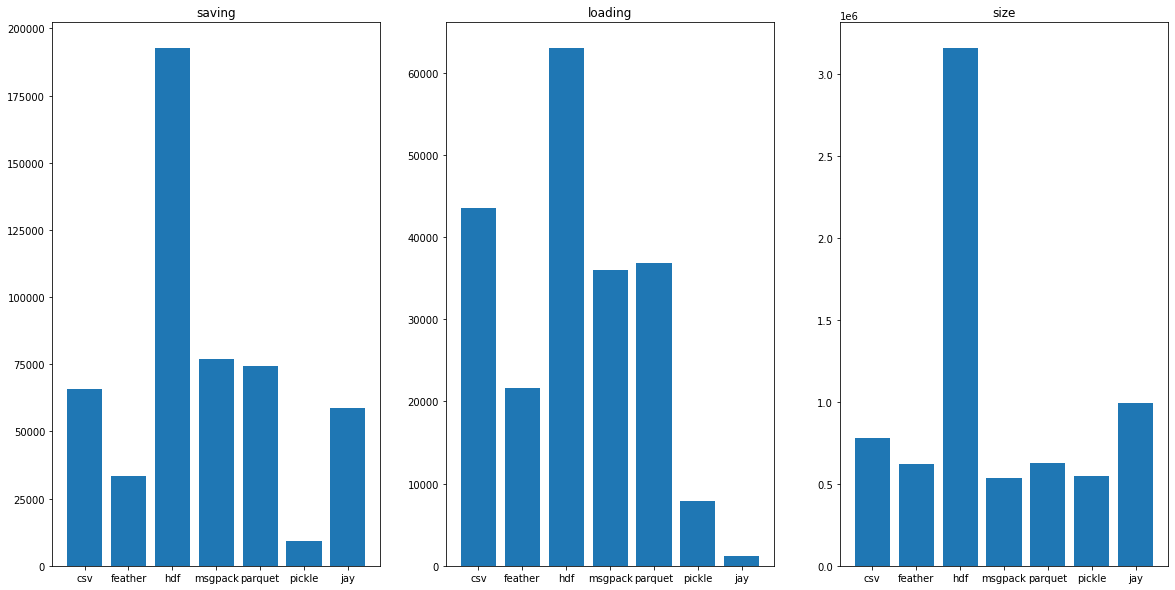

In [31]:
result = pd.DataFrame(columns=['file', 'save_time', 'load_time', 'size'])
for i in range(100) :
        result = pd.concat([result, main()])

print(result.groupby('file', as_index=False).mean())

fig = plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.bar(result['file'].values, result['save_time'].values)
plt.title('saving')
plt.subplot(1, 3, 2)
plt.bar(result['file'].values, result['load_time'].values)
plt.title('loading')
plt.subplot(1, 3, 3)
plt.bar(result['file'].values, result['size'].values)
plt.title('size')
plt.savefig('results/res1.png')
